In [1]:
from ml.nodes import *
from ml.traces import *
import tensorflow as tf

In [2]:
mnist = MNIST()
mnist.info()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
                                   MNIST:        0     N:-1 C:784 
Dataset: MNIST
  shape: N:-1 C:784 
  labels: 10
  test:       (10000, 784)
  validation: (5000, 784)
  train:      (55000, 784)


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [4]:
x = mnist.x
y_ = mnist.y_

In [5]:
x_im = Reshape(mnist, 'C', 'WHC', (28, 28, 1))
c = Conv2d(x_im, 5, 16, sd=.001, padding='VALID')
b = Bias(c, .001)
r = Relu(b)
mp1 = MaxPool(r, 5, stride=2, padding='SAME')

c2 = Conv2d(mp1, 5, 32, sd=.1)
b2 = Bias(c2, .001)
r2 = Relu(b2)
mp2 = MaxPool(r2, 5, stride=2, padding='SAME')

f = Flatten(mp2)

l4 = Linear(f, 10)
b4 = Bias(l4, .001)

s = SoftmaxCrossEntropyWithLogits(b4, y_)
sm = Softmax(b4)
ce = Mean(s)

acc = Accuracy(b4, y_)

                                 Reshape:        0     N:-1 W:28 H:28 C:1 
                                  Conv2d:      400     N:-1 W:24 H:24 C:16 
                                    Bias:       16     N:-1 W:24 H:24 C:16 
                                    Relu:        0     N:-1 W:24 H:24 C:16 
                                 MaxPool:        0     N:-1 W:12 H:12 C:16 
                                  Conv2d:    12800     N:-1 W:12 H:12 C:32 
                                    Bias:       32     N:-1 W:12 H:12 C:32 
                                    Relu:        0     N:-1 W:12 H:12 C:32 
                                 MaxPool:        0     N:-1 W:6 H:6 C:32 
                                 Flatten:        0     N:-1 C:1152 
                                  Linear:    11520     N:-1 C:10 
                                    Bias:       10     N:-1 C:10 
           SoftmaxCrossEntropyWithLogits:        0     N:-1 C:1 
                                 Softmax:        0    

In [6]:
rate = tf.placeholder(tf.float32)
train_step = tf.train.AdamOptimizer(rate).minimize(ce.out())
sess.run(tf.global_variables_initializer())

In [7]:
trackables = [ [ ScalarTrace(acc.out(), 'Accuracy',                 skip=50),
                 ScalarTrace(ce.out(),  'Cross Entropy', yFn='log', skip=50), ],
               [ BiasTrace(b.b, 'Conv1 Bias'),  WeightTrace(c.W, 'Conv1 Weights'),  OutTrace(b.out(), 'Out')],
               [ BiasTrace(b2.b, 'Conv2 Bias'), WeightTrace(c2.W, 'Conv2 Weights'), OutTrace(b2.out(), 'Out')],
               [ BiasTrace(b4.b, 'Lin1 Bias'),  WeightTrace(l4.W, 'Lin1 Weights'),  OutTrace(b4.out(), 'Out')],
               [ OutTrace(sm.out(), 'Softmax'),
                 TopTrace(sm.out(), 'Softmax/Top'),
                 TopTrace(sm.out(), 'Softmax/2nd', index=-2), ],
             ]

track = Track(trackables)

In [8]:
def train(track, epochs=200):
    nodes = track.nodes()
    for i in range(epochs):
        f = 1-float(i)/epochs
        lr = 1e-5 + (1e-3-1e-5) * f
        for j in range(100):
            batch = mnist.train.next_batch(50)
            vals = sess.run([train_step] + nodes, feed_dict={x: batch[0], y_: batch[1], rate:lr})
            track.addBatch(vals[1:])
        r = sess.run(nodes, feed_dict={x: mnist.validation.images(), y_: mnist.validation.labels()})
        print '%4d' % i,
        if (i+1) % 10 == 0:
            print '%8.04f %f' % (r[0]*100, lr)
        track.addEpoch(r)

In [9]:
train(track, epochs=200)

   0    1    2    3    4    5    6    7    8    9  97.9800 0.000955
  10   11   12   13   14   15   16   17   18   19  98.3200 0.000906
  20   21   22   23   24   25   26   27   28   29  98.8000 0.000856
  30   31   32   33   34   35   36   37   38   39  98.7000 0.000807
  40   41   42   43   44   45   46   47   48   49  98.9400 0.000757
  50   51   52   53   54   55   56   57   58   59  98.7400 0.000708
  60   61   62   63   64   65   66   67   68   69  98.8200 0.000658
  70   71   72   73   74   75   76   77   78   79  99.0800 0.000609
  80   81   82   83   84   85   86   87   88   89  99.2800 0.000559
  90   91   92   93   94   95   96   97   98   99  99.1600 0.000510
 100  101  102  103  104  105  106  107  108  109  99.1000 0.000460
 110  111  112  113  114  115  116  117  118  119  99.2400 0.000411
 120  121  122  123  124  125  126  127  128  129  99.2000 0.000361
 130  131  132  133  134  135  136  137  138  139  99.2600 0.000312
 140  141  142  143  144  145  146  147  148  14

In [10]:
print("test accuracy %8.04f" % 
          acc.out().eval(
            feed_dict={ x: mnist.test.images(), y_: mnist.test.labels()}))

test accuracy   0.9938


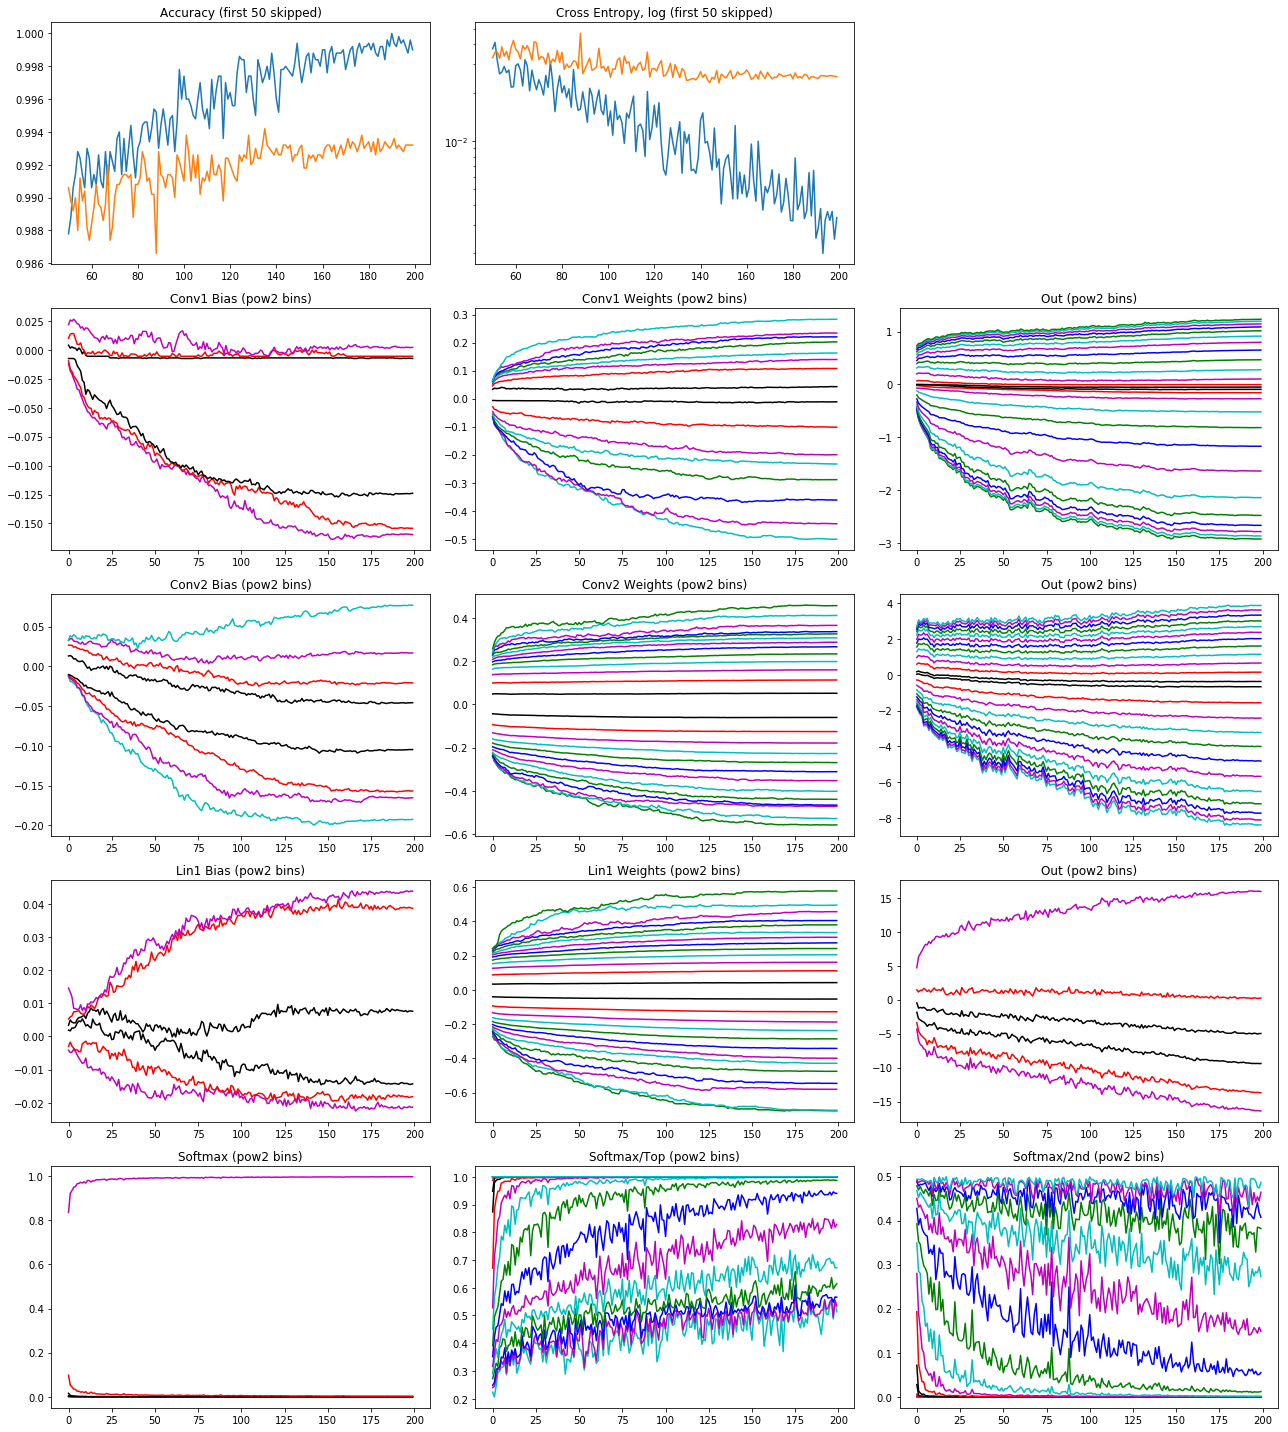

In [11]:
track.plotAll(width=18, height=20)

(5, 5, 1, 16)
(16, 5, 5, 1)


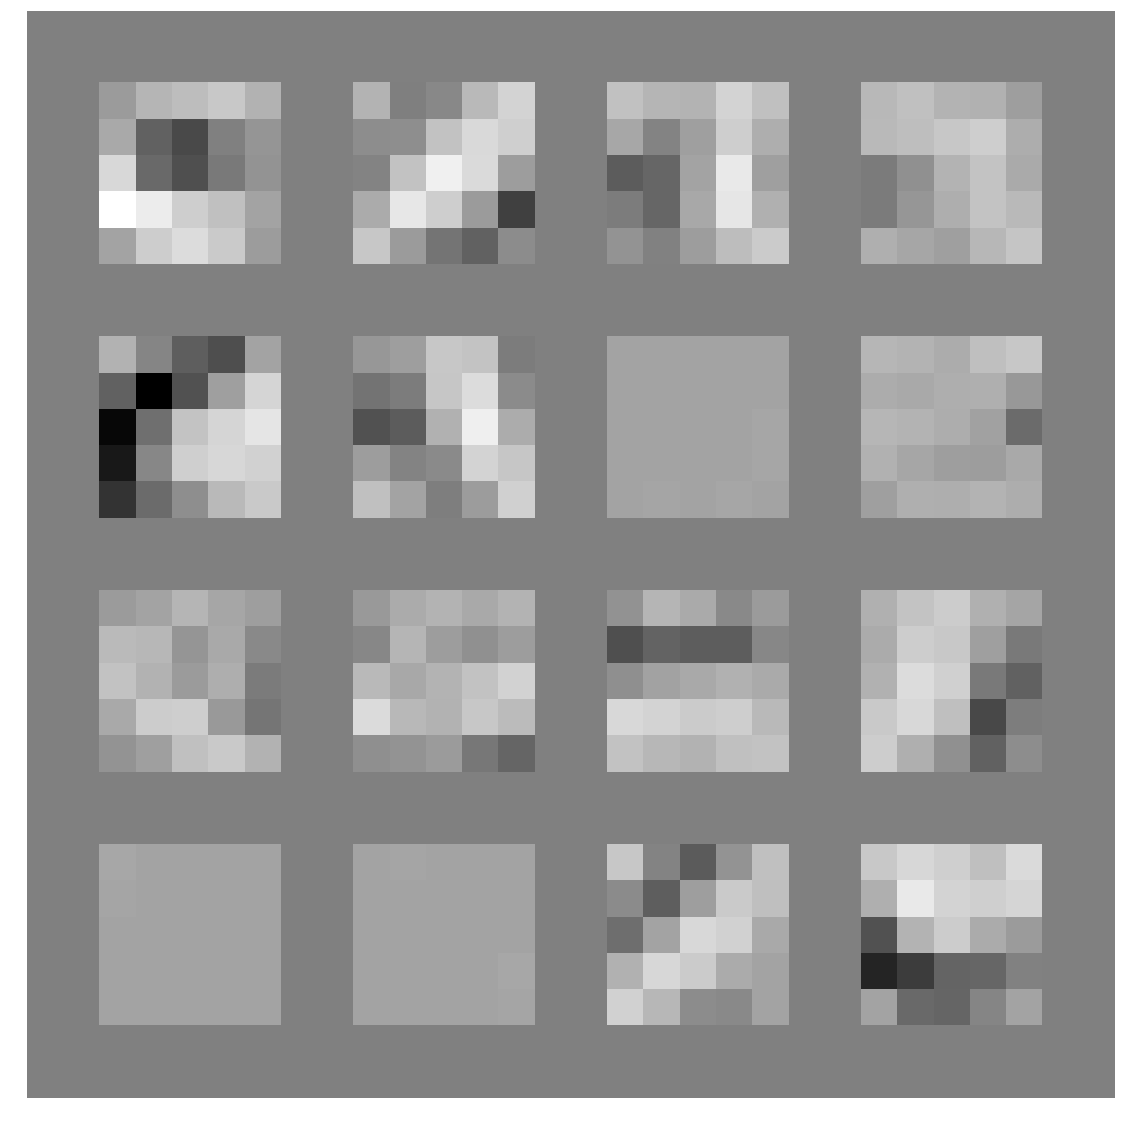

In [22]:
v = sess.run(c.W)
print v.shape
from ml.misc import show
v = v.transpose((3,0,1,2))
print v.shape
v = v.reshape(1,4,4,5,5,1)
mx = np.max(v, axis=None)
mn = np.min(v, axis=None)
v = (v - mn)/ (mx-mn)
show(v, 'NHWYXC')